In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from Network_bayesian import Place_net, Grid_net, Coupled_Net, Coupled_Net_crm, Place_net_crm
import brainpy as bp
import brainpy.math as bm
from matplotlib.animation import FuncAnimation
import time
from scipy.stats import ttest_ind, norm

# Circular distance function
def circ_dis(phi_1, phi_2):
  dis = phi_1 - phi_2
  dis = np.where(dis > np.pi, dis - 2 * np.pi, dis)
  dis = np.where(dis < -np.pi, dis + 2 * np.pi, dis)
  return dis


In [ ]:
# Default parameters
# grid spacing
lambda_1 = 3
lambda_2 = 4
lambda_3 = 5
Lambda = np.array([lambda_1, lambda_2, lambda_3])
L = lambda_1 * lambda_2 * lambda_3
# cell number
num_p = int(200)
rho_p = num_p / L
rho_g = rho_p
num_g = int(rho_g * 2 * np.pi)  # Ensure that the rho of the two networks is equal
M = len(Lambda)
# feature space
x = np.linspace(0, L, num_p, endpoint=False)
theta = np.linspace(0, 2 * np.pi, num_g, endpoint=False)
# connection range
a_p = 0.3
a_g = a_p / Lambda * 2 * np.pi
# connection strength
J_p = 20
J_g = J_p
J_pg = J_p / 25

# divisive normalization
k_p = 20.
k_g = Lambda / 2 / np.pi * k_p
# time constants
tau_p = 1
tau_g = 2 * np.pi * tau_p / Lambda
# input strength
alpha_p = 0.05
alpha_g = 0.05

noise_ratio = 0.007

L_crm = 6
z_min_crm = 30 - L_crm/2
z_max_crm = 30 + L_crm/2
P_CANN_1 = Place_net(z_min=0, z_max=L, num=num_p, a_p=a_p, k=k_p, tau=tau_p, J0=J_p, get_center_max=False)
P_CANN_2 = Place_net_crm(z_min=z_min_crm, z_max=z_max_crm, num=num_p)
# Grid cells
G_CANNs_1 = bm.NodeList()
G_CANNs_2 = bm.NodeList()
for i in range(M):
  G_CANNs_1.append(Grid_net(z_min=0, z_max=L, num=num_g, num_hpc=num_p, L=Lambda[i], a_g=a_g[i], k_mec=k_g[i], tau=tau_g[i], J0=J_g, W0=J_pg))
  G_CANNs_2.append(Grid_net(z_min=z_min_crm, z_max=z_max_crm, num=num_g, num_hpc=num_p, L=Lambda[i], a_g=a_g[i], k_mec=k_g[i], tau=tau_g[i], J0=J_g, W0=J_pg))

Coupled_model_1 = Coupled_Net(HPC_model=P_CANN_1, MEC_model_list=G_CANNs_1, num_module=M)
Coupled_model_2 = Coupled_Net_crm(HPC_model=P_CANN_2, MEC_model_list=G_CANNs_2, num_module=M)

def Net_decoding(Coupled_model, z_truth, phi_truth, Ip, Ig, alpha_p=0.05, alpha_g=0.05):
  Coupled_model.reset_state()
  def initial_net(Ip, Ig): 
    Coupled_model.initial(alpha_p=1, alpha_g=1, Ip=Ip, Ig=Ig)

  def run_net(i, Ip, Ig): 
    Coupled_model.step_run(i, alpha_p=1, alpha_g=1, Ip=Ip, Ig=Ig)
    phi_decode = Coupled_model.phase
    z_decode = Coupled_model.HPC_model.center
    rp = Coupled_model.HPC_model.r
    up = Coupled_model.HPC_model.u
    rg = bm.zeros([M, num_g])
    ug = bm.zeros([M, num_g])
    for mi in range(M):
      rg[mi, :] = Coupled_model.MEC_model_list[mi].r
      ug[mi, :] = Coupled_model.MEC_model_list[mi].u
    return z_decode, phi_decode, rp, up, rg, ug

  T_init = 500
  z0 = z_truth
  phi_0 = phi_truth
  fg = np.zeros((M, num_g))
  for i in range(M):
    dis_theta = circ_dis(theta, phi_0[i])
    fg[i, :] = np.exp(-dis_theta ** 2 / (4 * a_g[i] ** 2))
  dis_x = x - z0
  fp = np.exp(-dis_x ** 2 / (4 * a_p ** 2))
  I_place = 1 * np.repeat(fp[np.newaxis, :], T_init, axis=0)
  I_grid = 1 * np.repeat(fg[np.newaxis, :, :], T_init, axis=0)
  I_place[int(T_init / 3):, :] = 0
  I_grid[int(T_init / 3):, :, :] = 0

  bm.for_loop(initial_net, (I_place, I_grid), progress_bar=False)
  T = 5000
  indices = np.arange(T)
  I_place = alpha_p * np.repeat(Ip[np.newaxis, :], T, axis=0)
  I_grid = alpha_g * np.repeat(Ig[np.newaxis, :, :], T, axis=0)
  z_record, phi_record, rp, up, rg, ug = bm.for_loop(run_net, (indices, I_place, I_grid), progress_bar=False)

  return z_record, phi_record, up, rp, ug, rg


def Net_crm_decoding(Coupled_model, Ig, alpha_g=0.05):
  Coupled_model.reset_state()

  def run_net(i, Ig): 
    Coupled_model.step_run(i, alpha_g=1, Ig=Ig)
    z_decode = Coupled_model.HPC_model.center
    rp = Coupled_model.HPC_model.r
    I_mec = Coupled_model.I_mec
    return z_decode, rp, I_mec

  T = 5000
  indices = np.arange(T)
  I_grid = alpha_g * np.repeat(Ig[np.newaxis, :, :], T, axis=0)
  z_decode, rp, I_mec = bm.for_loop(run_net, (indices, I_grid), progress_bar=False)

  return z_decode, rp, I_mec


In [ ]:
c = 0.  # Constant for off-diagonal positions
# Generate a matrix filled with the constant c
Sigma_G = np.full((num_g, num_g), c)
Sigma_P = np.full((num_p, num_p), c)
np.fill_diagonal(Sigma_G, 1)  # Set diagonal elements to 1
np.fill_diagonal(Sigma_P, 1)  # Set diagonal elements to 1
Lg = np.linalg.cholesky(Sigma_G)  # Cholesky decomposition of Sigma_G
Lp = np.linalg.cholesky(Sigma_P)  # Cholesky decomposition of Sigma_P


In [ ]:

# Main Program
neural_noise_sigma = 0.4
trial_num = 100
z_truth = 30
phi_truth = np.mod(z_truth / Lambda, 1) * 2 * np.pi 
sigma_phi = np.array([31.7,23.8,19])*neural_noise_sigma/20

z_decode_crm = np.zeros(trial_num)
z_decode_net = np.zeros(trial_num)

start_time = time.time()

for i in range(trial_num):
    z_truth = 30
    phi_truth = np.mod(z_truth / Lambda, 1) * 2 * np.pi 
    z_e = z_truth
    psi = phi_truth + sigma_phi * np.random.randn(M)
    Ig = np.zeros((M, num_g))
    for j in range(M):
        dis_theta = circ_dis(theta, psi[j])
        noise_g = neural_noise_sigma * np.random.randn(num_g)
        noise_corr_g = Lg @ noise_g
        Ig[j, :] = np.exp(-dis_theta ** 2 / (4 * a_g[j] ** 2)) + noise_corr_g
        # Ig[j, :] = np.exp(-dis_theta ** 2 / (4 * a_g[j] ** 2)) + neural_noise_sigma * np.random.randn(num_g)
    dis_x = x - z_e
    Ip = 0*(np.exp(-dis_x ** 2 / (4 * a_p ** 2)) + neural_noise_sigma * np.random.randn(num_p) )
    z_decode_n1, _, _, _, _, _ = Net_decoding(Coupled_model_1, z_truth, phi_truth, Ip, Ig)
    z_decode_n2, _, _ = Net_crm_decoding(Coupled_model_2, Ig)

    z_decode_net[i] = z_decode_n1[-1]
    z_decode_crm[i] = z_decode_n2[-1]
    if i % 5 == 0:
        print(f"Progress: {i/trial_num*100:.2f}%")

end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")


# save results
np.savez('results/cth/CRM_vs_Net_distribution.npz', z_decode_net=z_decode_net, z_decode_crm=z_decode_crm)

Progress: 0.00%
Progress: 5.00%
Progress: 10.00%
Progress: 15.00%
Progress: 20.00%
Progress: 25.00%
Progress: 30.00%
Progress: 35.00%
Progress: 40.00%
Progress: 45.00%
Progress: 50.00%
Progress: 55.00%
Progress: 60.00%
Progress: 65.00%
Progress: 70.00%
Progress: 75.00%
Progress: 80.00%
Progress: 85.00%
Progress: 90.00%
Progress: 95.00%
Total runtime: 274.99 seconds


Net decoding error: 0.20638910078339254
MAP decoding error: 0.2707750685052616


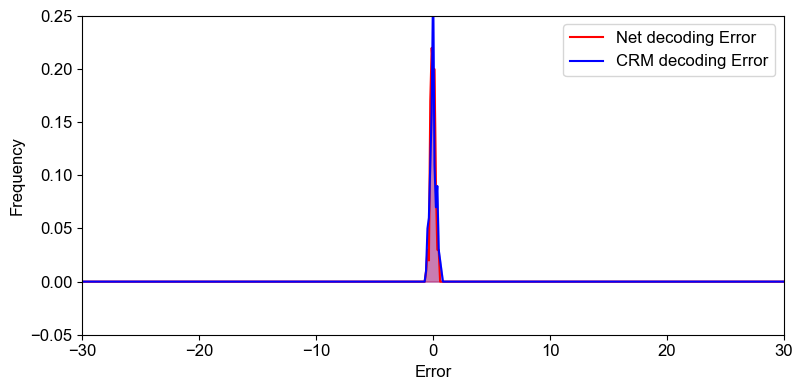

In [ ]:

z_decode_all = np.concatenate([z_decode_net, z_decode_crm])
min_z = np.min(z_decode_all)
max_z = np.max(z_decode_all)

# set font
plt.rcParams.update({'font.size': 12, 'font.family': 'Arial'})
error_Net = z_decode_net-z_truth
error_CRM = z_decode_crm-z_truth
print('Net decoding error:', np.std(error_Net))
print('MAP decoding error:', np.std(error_CRM))

# Compute the histogram for the PSC and LSC errors
counts_psc, bin_edges_psc = np.histogram(error_CRM, bins=np.linspace(-30,30,500))
counts_lsc, bin_edges_lsc = np.histogram(error_Net, bins=np.linspace(-30,30,500))

# Calculate the bin centers
bin_centers_psc = (bin_edges_psc[:-1] + bin_edges_psc[1:]) / 2
bin_centers_lsc = (bin_edges_lsc[:-1] + bin_edges_lsc[1:]) / 2

# Remove zero points
# nonzero_indices_lsc = counts_lsc > 0
# bin_centers_lsc = bin_centers_lsc[nonzero_indices_lsc]
# counts_lsc = counts_lsc[nonzero_indices_lsc]

# Plot the histogram with non-zero points only
plt.figure(figsize=(8, 4))
plt.plot(bin_centers_lsc, counts_lsc/np.sum(counts_lsc), label='Net decoding Error', color='red')
plt.plot(bin_centers_psc, counts_psc/np.sum(counts_psc), label='CRM decoding Error', color='blue')

plt.fill_between(bin_centers_psc, counts_psc/np.sum(counts_psc), color='blue', alpha=0.3)
plt.fill_between(bin_centers_lsc, counts_lsc/np.sum(counts_lsc), color='red', alpha=0.3)

plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.ylim(-0.05,0.25)
plt.xlim(-30,30)
plt.savefig('figures_cth/CRM_vs_NET.pdf')
plt.show()


